In [28]:
import pandas as pd
from datetime import datetime
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import mplcursors
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px
from catboost import CatBoostRegressor

In [7]:
categorical_columns = ['vehicle_make', 'vehicle_model', 'city']
columns_to_be_dropped = ['month_of_vehicle_manufacture', 'year_of_vehicle_manufacture', 'registered_color', 'vehicle_fuel_type', 'accidental_vehicle', 
                         'car_variant', 'Odometer_Reading_Present']

# return integer month, from string, default is 6
def month_to_number(month):
    if pd.isna(month):
        return 6
    try:
        # Try to convert directly to an integer
        month_number = int(month)
        if 1 <= month_number <= 12:
            return month_number
    except ValueError:
        # If month is a string, convert it to lower case and map to month number
        month = month.lower()
        month_dict = {
            'january': 1, 'february': 2, 'march': 3,
            'april': 4, 'may': 5, 'june': 6,
            'july': 7, 'august': 8, 'september': 9,
            'october': 10, 'november': 11, 'december': 12
        }
        return month_dict.get(month, 6)  # Return 6 if month is not recognized
    return 6

# Function to calculate count of months since manufacting data(year, month)
def calculate_months_since_manufactured(row, current_year, current_month):
    year, month = row['year_of_vehicle_manufacture'], row['month_of_vehicle_manufacture']
    return (current_year - year) * 12 + (current_month - month)
    
# Fuction to mark columns as category type
def convert_columns_as_category(columns, data):
    for column in columns:
        data[column] = data[column].astype('category')

# Convert values to uppercase
def convert_values_to_uppercase(columns, data):
    for column in columns:
        data[column] = data[column].str.strip()
        data[column] = data[column].str.upper()

# Replace text which is matching with a pattern
def replace_text(pattern, data, column):
    data[column] = data[column].str.replace(pattern, '', regex=True)

# Prune data
def prune_data(data):
    # set month number, considering string, int, nan cases 
    data['month_of_vehicle_manufacture'] = data['month_of_vehicle_manufacture'].apply(month_to_number)
    # add months_since_manufactured column
    data['months_since_manufactured'] = data.apply(calculate_months_since_manufactured, axis=1, current_year=datetime.now().year, current_month=datetime.now().month)
    # remove redundant features
    data = data.drop(columns=columns_to_be_dropped, axis=1)
    # convert values to uppercase
    convert_values_to_uppercase(categorical_columns, data)
    # remove yyyy-yyyy or yyyy from vehicle_model
    pattern = r'\b\d{4}-\d{4}\b|\b\d{4}\b'
    replace_text(pattern, data, 'vehicle_model')
    # mark columns as category type
    convert_columns_as_category(categorical_columns, data)
    return data

def plot_errors(x_axis, test_errors, train_errors):
    # Activate interactive plot in separate window
    %matplotlib qt
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Plot the data
    ax.plot(x_axis, test_errors, label='Test Errors', marker='o')
    ax.plot(x_axis, train_errors, label='Train Errors', marker='o')
    # Add labels and title
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Error')
    ax.set_title('Zoomable Graph with Test and Train Errors')
    # Enable interactive cursor for zooming
    mplcursors.cursor(hover=True)
    # Add legend
    plt.legend()
    # Display the plot
    plt.show()

def plot_feature_importance(model, columns):
    feature_importances = model.feature_importances_  
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': columns,
        'Importance': feature_importances
    })
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    # Visualize the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()
    plt.show()
    
def train_model(df, model):
    train_data = df.sample(frac = 0.9)
    test_data = df.drop(train_data.index)
    train_inputs = train_data.drop(columns=['car_valuation'], axis=1)
    train_output = train_data['car_valuation']
    print(train_inputs.sample())
    test_inputs = test_data.drop(columns=['car_valuation'], axis=1)
    test_output = test_data['car_valuation']
    model.fit(train_inputs, train_output)
    # mean absolute error on train data
    train_prediction = model.predict(train_inputs)
    train_error = mean_absolute_error(train_prediction, train_output)
    # mean absolute error on test data
    test_predicted_output = model.predict(test_inputs)
    test_error = mean_absolute_error(test_predicted_output, test_output)
    print("test_error= ",test_error," train_error= ", train_error)
    # Plot Feature Importance
    # plot_feature_importance(model, train_inputs.columns)
    return test_error, train_error

# Training
def prune_data_and_train_model(data, model):
    data = prune_data(data)
    data = data.drop(columns=['id'], axis=1)
    train_model(data, model)

In [8]:
# return ids and predicted outcome using model
def run_model(data, model):
    ids = data['id']
    data = data.drop(columns=['id'], axis=1)
    predicted_output = model.predict(data)
    return ids, predicted_output

# predict outcomes and save in file
def predict_output_and_save(ids_original_order, data, model):
    ids, car_valuations = run_model(data, model)
    car_valuations = car_valuations.astype(int)
    df = pd.DataFrame({
        'id': ids,
        'car_valuation': car_valuations
    })
    df.to_csv('/Users/vikash.yadav/Documents/data_science_hackathon/car_valuation_data.csv', index=False)

def predict_output(data, model):
    ids = data['id']
    data = prune_data(data)
    data.to_csv('/Users/vikash.yadav/Documents/data_science_hackathon/pruned_data.csv', index=False)
    print(data.columns)
    predict_output_and_save(ids, data, model)

In [9]:
test_data = pd.read_csv('/Users/vikash.yadav/Documents/data_science_hackathon/test.csv')

In [10]:
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5
)

data = pd.read_csv('/Users/vikash.yadav/Documents/data_science_hackathon/train.csv')
prune_data_and_train_model(data, model)
predict_output(test_data, model)

     odometer_reading vehicle_make vehicle_model   city  \
407           82150.0      HYUNDAI         VERNA  SURAT   

     months_since_manufactured  
407                        117  


ValueError: could not convert string to float: 'MARUTI'

In [ ]:
param_grid = {
    'iterations': [1000, 3000],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'depth': [4, 6, 10],
    'border_count': [128, 254, 500],
    'subsample': [1],
    'verbose': [500]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_absolute_error', verbose=2)
data = pd.read_csv('/Users/vikash.yadav/Documents/data_science_hackathon/train.csv')
prune_data_and_train_model(data, grid_search)
predict_output(test_data, model)

In [ ]:
# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best estimator
best_model = grid_search.best_estimator_
print("Best model", best_model)

In [ ]:
# return ids and predicted outcome using model
def run_model(data, model):
    ids = data['id']
    data = data.drop(columns=['id'], axis=1)
    predicted_output = model.predict(data)
    return ids, predicted_output

# predict outcomes and save in file
def predict_output_and_save(ids_original_order, data, model):
    ids, car_valuations = run_model(data, model)
    car_valuations = car_valuations.astype(int)
    df = pd.DataFrame({
        'id': ids,
        'car_valuation': car_valuations
    })
    df.to_csv('/Users/vikash.yadav/Documents/data_science_hackathon/car_valuation_data.csv', index=False)

def predict_output(data, model):
    ids = data['id']
    data = prune_data(data)
    data.to_csv('/Users/vikash.yadav/Documents/data_science_hackathon/pruned_data.csv', index=False)
    print(data.columns)
    predict_output_and_save(ids, data, model)

len(stats_by_make) 11                           JEEP
1                             BMW
10                         JAGUAR
9                           ISUZU
0                            AUDI
32                   TOYOTA ETIOS
20                             MG
21         MG MOTOR INDIA PVT LTD
33    TOYOTA KIRLOSKAR MOTORS LTD
18                       MERCEDES
12                            KIA
19                  MERCEDES-BENZ
31                         TOYOTA
13                       MAHINDRA
26                        RENUALT
30                TATA MOTORS LTD
14    MAHINDRA & MAHINDRA LIMITED
28       SKODA AUTO INDIA PVT LTD
29                           TATA
8                         HYUNDAI
Name: vehicle_make, dtype: category
Categories (35, object): ['AUDI', 'BMW', 'DATSUN', 'FORD', ..., 'TOYOTA', 'TOYOTA ETIOS', 'TOYOTA KIRLOSKAR MOTORS LTD', 'VOLKSWAGEN']


/var/folders/ct/ddld0_kj0j1_pw204s71y1jh0000gq/T/ipykernel_82497/2789662163.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



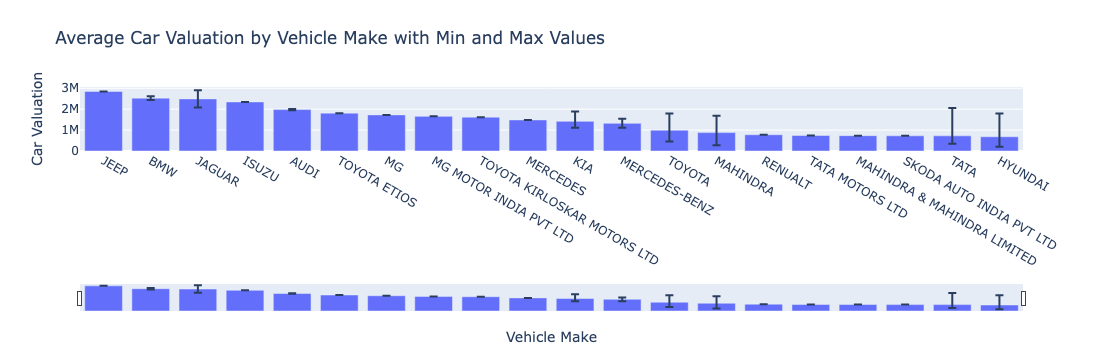

In [27]:
def plot_car_valuation_by_maker(df):
    # Calculate the mean, min, and max car valuation by vehicle make
    stats_by_make = df.groupby('vehicle_make')['car_valuation'].agg(['mean', 'min', 'max']).reset_index()
    
    # Sort by average car valuation
    stats_by_make = stats_by_make.sort_values(by='mean', ascending=False).head(20)

    print("len(stats_by_make)", stats_by_make['vehicle_make'])
    
    
    
    # Create the plot using Plotly
    fig = px.bar(stats_by_make, x='vehicle_make', y='mean', 
                 error_y=stats_by_make['max'] - stats_by_make['mean'], 
                 error_y_minus=stats_by_make['mean'] - stats_by_make['min'],
                 labels={'mean':'Average Car Valuation', 'vehicle_make':'Vehicle Make'},
                 title='Average Car Valuation by Vehicle Make with Min and Max Values')
    
    # Update layout for better visualization
    fig.update_layout(
        xaxis_title='Vehicle Make',
        yaxis_title='Car Valuation',
        hovermode='x unified'
    )
    
    # Enable zooming
    fig.update_layout(
        xaxis=dict(
            rangeslider=dict(
                visible=True
            ),
            type="category"
        )
    )
    
    # Show the plot
    fig.show()

df = pd.read_csv('/Users/vikash.yadav/Documents/data_science_hackathon/train.csv')
df = prune_data(df)
plot_car_valuation_by_maker(df)

In [26]:
premium_car_makers = ['JEEP', 'BMW', 'JAGUAR', 'ISUZU', 'AUDI', 'TOYOTA ETIOS', 'MG', 'MG MOTOR INDIA PVT LTD',
                      'TOYOTA KIRLOSKAR MOTORS LTD', 'MERCEDES', 'KIA', 'MERCEDES-BENZ']